In [4]:
# IMPORTS
using FFTW, Plots
using DSP: unwrap

In [28]:
# CONSTANTS
c = 299792458

# Waveguide
β2 = -2.168e-26
L = 5_000
α = 0*0.046e-3
γ = 1.1e-3
λc = 1.55e-6 
ω0 = 2π*c/λc
# Signal 
T = 200e-12 # Duration
N = 2^13 # Time samples
Ns = 1 # Soliton number
Δτ =19.2e-12 # FWHM
τ = Δτ/1.7627
P = abs(β2)/(γ*τ^2)
# Vectors 
βs = [0.0, β2]
t = T*(-N÷2:N÷2-1)/N;
ν = fftshift((-N÷2:N÷2-1)./T);
ω = 2π.*ν;

u0 = sqrt(P)*sech.(t ./ τ);

In [29]:
NL1(u) = 1.0im .* γ * FFT*(u .* abs2.(u))

function NL2(u)
	IT = u .* abs2.(u)
	1.0im .* γ * FFT*(IT .- IFFT*(ω .* FFT*IT) ./ ω0)
end


function _compute_error(a, b) # MSD
	sqrt(sum(abs2.(a .- b)) ./ sum(abs2.(a)))
end

# Simulation parameters 
NL = NL1
dz = 1  # in percent 
reltol = 1e-6
maxiters = 2
zk = 0
it = 0
k5 = nothing
zs = []
ϵ_hist = []
u = ComplexF64.(u0)

FFT = plan_fft(u)
IFFT = plan_ifft(u)

U = FFT*u
NU = NL(u)

D = -0.5α .+ 1im*sum([ (βs[i]/factorial(i)) .*ω.^i for i in eachindex(βs) ]);


while zk < L

	e = exp.(0.5 * dz * D)
	Uip = e .* U
	k1 = e .* NU
#= 	if isnothing(k5)
		k1 = e .* ifft(U)
	else
		k1 = D .* k5
	end =#

	k2 = NL(IFFT*(Uip .+ 0.5 * dz * k1))

	k3 = NL(IFFT*(Uip .+ 0.5 * dz * k2))

	k4 = NL(IFFT*(e .* (Uip .+ dz * k3)))

	r = e .* (Uip .+ dz * (k1 / 6.0 .+ k2 / 3.0 .+ k3 / 3.0))

	U1 = r .+ dz * k4 / 6.0

	k5 = NL(IFFT*U1)

	U2 = r .+ dz * (k4 / 15.0 .+ k5 / 10.0)

	err = _compute_error(U1, U2)
	
	dzopt = max(0.5, min(2.0, 0.9 * sqrt(sqrt(reltol / err)))) * dz

	if err <= reltol

		zk = zk + dz
		dz = min(dzopt, L - zk)
		append!(ϵ_hist, err)
		U = U1
		NU = k5
	else
		dz = dzopt
		it = it + 1
		if (it >= maxiters)
			throw(ErrorException("Max number of iteration exceeded!"))
		end
	end
end

sol = IFFT*U


8192-element Vector{ComplexF64}:
 0.00010474713497954369 + 9.284617584202903e-5im
 0.00010474601895624214 + 9.284605079257213e-5im
 0.00010474842563290565 + 9.285207425308029e-5im
  0.0001047491825743041 + 9.286015791784563e-5im
 0.00010475319146130424 + 9.286935262231566e-5im
  0.0001047620233629587 + 9.28811752687192e-5im
 0.00010477064432440342 + 9.289237213136459e-5im
 0.00010477826451135708 + 9.289840515809555e-5im
 0.00010478496794352754 + 9.290526294557233e-5im
   0.000104795683449177 + 9.291558088299345e-5im
                        ⋮
 0.00010479568344919088 + 9.291558088290325e-5im
 0.00010478496794358305 + 9.290526294553764e-5im
  0.0001047782645113779 + 9.289840515814066e-5im
  0.0001047706443245075 + 9.289237213141663e-5im
 0.00010476202336290319 + 9.288117526877124e-5im
 0.00010475319146141526 + 9.28693526223677e-5im
 0.00010474918257423471 + 9.286015791788726e-5im
  0.0001047484256328085 + 9.285207425305947e-5im
 0.00010474601895631153 + 9.284605079256866e-5im

In [26]:
it 

0

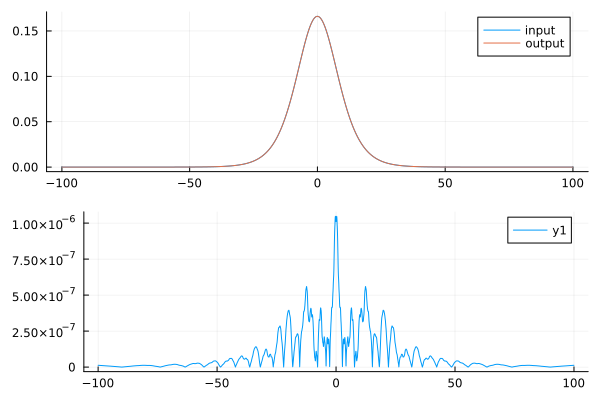

In [30]:
p1 = plot();
plot!(p1,t*1e12, abs2.(u0), label="input");
plot!(p1,t*1e12, abs2.(sol), label="output");

p2 = plot()
plot!(p2,t*1e12, (abs.(abs2.(u0).-abs2.(sol))))

plot(p1,p2, layout=[1,1])

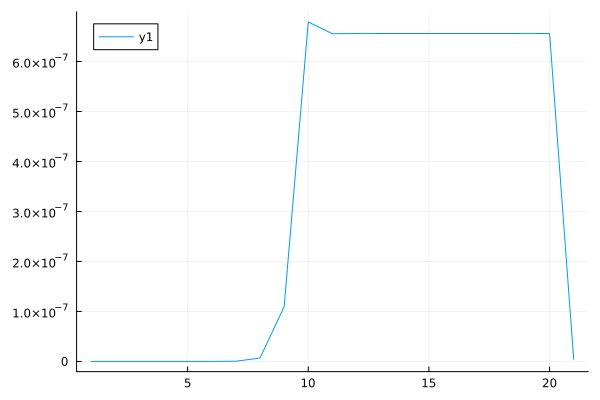

In [31]:
plot(ϵ_hist)

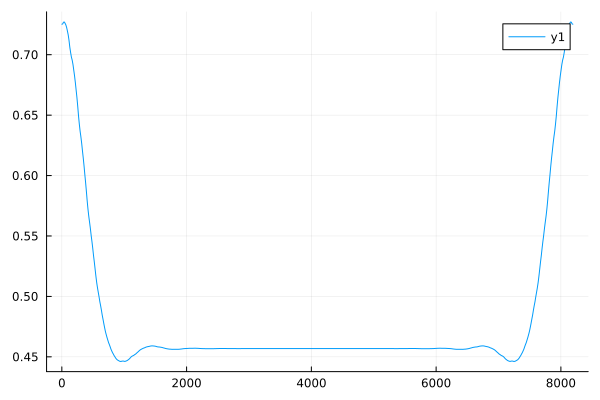

In [32]:
plot(unwrap(angle.(sol)))

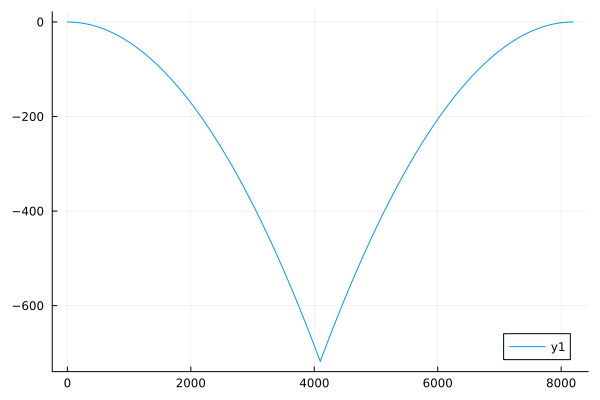

In [13]:
plot(imag.(D))